In [226]:
# !pip install -U pystad

In [4]:
import json
import stad as sd
import numpy as np
import pandas as pd
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt
from pyArango.connection import *
import networkx as nx

Falling back to slow stad.sparse implementation
Falling back to slow stad.sparse implementation
Falling back to slow stad.sparse implementation
Falling back to slow stad.objective implementation
Falling back to slow stad.masks implementation
Falling back to slow stad.lenses implementation


In [6]:
# format of credentials.json:
#     { "url": "http://localhost:8529",
#       "databaseName": "<YOURDATABASE>",
#       "auth": { "username": "<YOURUSERNAME>", "password": "<YOURPASSWORD" }
#     }

credentials = json.load(open('credentials.json'))
# print(credentials)

In [7]:
conn = Connection(username=credentials["auth"]["username"], password=credentials["auth"]["password"])
db = conn[credentials["databaseName"]]

In [8]:
# collection 'murih_samples' looks like this:
# [{
#     "_key": "IAM01_1",
#     "_id": "murih_samples/IAM01_1",
#     "_rev": "_dimFSyO---",
#     "individual": "IAM01",
#     "age": 58,
#     "gender": "M",
#     "X__Saturatie": -1.090955188,
#     "Albumine": -0.688442937,
#     "Albumine____": 0.706384552,
#     "Aldosteron": 1.598158214,
#     "Alfa_1_globulinen": -1.139896645,
#     "Alfa_2_globulinen": 0.34075838,
#     ...

aql = "FOR x IN murih_samples RETURN x"
queryResult = db.AQLQuery(aql, rawResults=True, batchSize=100)
data = pd.DataFrame(queryResult)


In [9]:
data

,_key,_id,_rev,individual,age,gender,X__Saturatie,Albumine,Albumine____,Aldosteron,...,Transcortine,Transferrine,Triglyceriden,Trombocyten,Ureum,Urinezuur,Urinezuur__mg_dL_,Urinezuur_creat__ratio,Vrij_plasmacortisol,Zink__serum_
0,IAM01_1,murih_samples/IAM01_1,_dimFSyO---,IAM01,58,M,-1.090955,-0.688443,0.706385,1.598158,...,-0.575249,-0.032318,0.290758,-0.755801,-0.036014,0.556676,0.176864,-0.198018,0.184115,-0.186774
1,IAM01_2,murih_samples/IAM01_2,_dimFSyO--_,IAM01,58,M,-1.486999,-0.688443,1.238920,0.585363,...,-1.101589,-0.057768,2.158593,-0.496982,0.338663,-0.407685,-0.167747,-0.417158,0.835148,0.252193
2,IAM01_3,murih_samples/IAM01_3,_dimFSyO--A,IAM01,58,M,0.196189,-0.688443,1.274423,1.215971,...,-1.035796,0.349437,1.540460,-0.949916,0.338663,0.170932,0.693780,-0.475595,0.770045,-0.333097
3,IAM01_4,murih_samples/IAM01_4,_dimFSyO--B,IAM01,58,M,-1.189966,-0.356091,1.380930,-0.102574,...,-0.838419,0.400338,0.868578,-0.432278,-0.160906,-1.034520,0.090711,-0.745867,0.379425,-1.211032
4,IAM01_5,murih_samples/IAM01_5,_dimFSyS---,IAM01,58,M,-0.397878,-0.356091,1.451934,-0.121683,...,-0.641042,0.374887,1.204519,-0.712665,0.463556,-0.166595,0.176864,0.335222,-0.206505,-0.845226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,IAM30_9,murih_samples/IAM30_9,_dimFSzi--I,IAM30,45,F,0.493222,1.638019,0.599877,-0.064355,...,-0.706834,0.960245,-0.166122,0.904953,0.338663,-0.793430,-0.340053,0.298699,1.811697,0.398516
374,IAM30_10,murih_samples/IAM30_10,_dimFSzi--J,IAM30,45,F,-0.397878,0.308612,0.564375,-0.962494,...,-0.443664,0.273086,-0.300499,-0.367573,-0.910261,-0.214813,-0.167747,-0.095753,2.527834,0.544839
375,IAM30_11,murih_samples/IAM30_11,_dimFSzi--K,IAM30,45,F,1.582343,1.305668,0.706385,2.171439,...,-0.443664,0.451238,-0.623003,-0.885211,-0.160906,0.797767,-0.598511,-0.446376,1.225768,-0.186774
376,IAM30_12,murih_samples/IAM30_12,_dimFSzi--L,IAM30,45,F,-0.397878,-0.023739,0.528873,-0.465651,...,-0.772627,-0.592225,-0.770817,-0.647960,0.463556,1.279948,-0.684663,0.327917,1.160664,-0.406258


## STAD on observations

In [10]:
df = pd.read_csv("IAF_clinical_cosine.csv", sep=",")
df

,Unnamed: 0,IAM01 1,IAM01 10,IAM01 11,IAM01 12,IAM01 13,IAM01 2,IAM01 3,IAM01 4,IAM01 5,...,IAM30 12,IAM30 13,IAM30 2,IAM30 3,IAM30 4,IAM30 5,IAM30 6,IAM30 7,IAM30 8,IAM30 9
0,IAM01 1,1.000000,0.916544,0.925298,0.963757,0.911155,0.968516,0.963208,0.934062,0.956535,...,0.819857,0.839155,0.818012,0.743864,0.789436,0.844889,0.852368,0.808686,0.824710,0.797484
1,IAM01 10,0.916544,1.000000,0.936478,0.947327,0.923246,0.903073,0.925943,0.896451,0.905737,...,0.838166,0.815569,0.833778,0.767384,0.755222,0.840831,0.875411,0.783128,0.816948,0.802244
2,IAM01 11,0.925298,0.936478,1.000000,0.933364,0.907171,0.934173,0.936361,0.920119,0.942609,...,0.808126,0.848249,0.832224,0.815247,0.805218,0.833266,0.865943,0.845740,0.855698,0.859736
3,IAM01 12,0.963757,0.947327,0.933364,1.000000,0.928626,0.959793,0.931743,0.927551,0.946870,...,0.836759,0.831000,0.824373,0.752545,0.784633,0.850292,0.872903,0.811758,0.819816,0.824598
4,IAM01 13,0.911155,0.923246,0.907171,0.928626,1.000000,0.916562,0.895443,0.869569,0.907990,...,0.791950,0.783664,0.749908,0.685323,0.714236,0.775597,0.810208,0.740730,0.760290,0.748085
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
373,IAM30 5,0.844889,0.840831,0.833266,0.850292,0.775597,0.842898,0.847701,0.830894,0.844557,...,0.896647,0.914950,0.951654,0.869347,0.874005,1.000000,0.944060,0.876483,0.899982,0.909402
374,IAM30 6,0.852368,0.875411,0.865943,0.872903,0.810208,0.853366,0.861257,0.829868,0.865435,...,0.916816,0.919185,0.961484,0.880574,0.873460,0.944060,1.000000,0.911421,0.921181,0.914376
375,IAM30 7,0.808686,0.783128,0.845740,0.811758,0.740730,0.805558,0.834810,0.861694,0.853790,...,0.823285,0.958569,0.905798,0.940270,0.917291,0.876483,0.911421,1.000000,0.967348,0.955909
376,IAM30 8,0.824710,0.816948,0.855698,0.819816,0.760290,0.812775,0.862654,0.873908,0.851747,...,0.855289,0.969719,0.922256,0.952836,0.931015,0.899982,0.921181,0.967348,1.000000,0.955435


In [11]:
del df["Unnamed: 0"]

In [12]:
similarities = df.to_numpy()
similarities

array([[1.        , 0.916544  , 0.92529761, ..., 0.8086861 , 0.82470984,
        0.79748442],
       [0.916544  , 1.        , 0.93647771, ..., 0.78312767, 0.81694828,
        0.80224397],
       [0.92529761, 0.93647771, 1.        , ..., 0.8457399 , 0.85569833,
        0.8597362 ],
       ...,
       [0.8086861 , 0.78312767, 0.8457399 , ..., 1.        , 0.96734838,
        0.95590941],
       [0.82470984, 0.81694828, 0.85569833, ..., 0.96734838, 1.        ,
        0.95543522],
       [0.79748442, 0.80224397, 0.8597362 , ..., 0.95590941, 0.95543522,
        1.        ]])

In [13]:
euc_observations_square = 1-similarities
euc_observations_square

array([[0.        , 0.083456  , 0.07470239, ..., 0.1913139 , 0.17529016,
        0.20251558],
       [0.083456  , 0.        , 0.06352229, ..., 0.21687233, 0.18305172,
        0.19775603],
       [0.07470239, 0.06352229, 0.        , ..., 0.1542601 , 0.14430167,
        0.1402638 ],
       ...,
       [0.1913139 , 0.21687233, 0.1542601 , ..., 0.        , 0.03265162,
        0.04409059],
       [0.17529016, 0.18305172, 0.14430167, ..., 0.03265162, 0.        ,
        0.04456478],
       [0.20251558, 0.19775603, 0.1402638 , ..., 0.04409059, 0.04456478,
        0.        ]])

In [14]:
eccentricities = []
for o in euc_observations_square:
    eccentricities.append(sum(o))
eccentricities

[63.814592843032194,
 66.03981087120715,
 62.31033353170513,
 61.94482423393657,
 81.51263480740842,
 66.04783462732503,
 61.13097638197146,
 69.01647816766254,
 59.88062325242028,
 59.345819186373014,
 68.82104248876215,
 86.08724057148758,
 63.93101919903131,
 63.597679120736125,
 72.74451619899398,
 60.70302014908358,
 70.29744617029054,
 76.1395873853616,
 63.548264408050755,
 64.20773827568829,
 63.78733034684114,
 68.65138631030321,
 78.30871094959465,
 64.88458495586849,
 68.95040011461585,
 63.70870164128411,
 99.4353130546965,
 69.8809602824334,
 74.87180990068047,
 72.90456562104362,
 69.57202100074149,
 73.230314988407,
 80.16646661031378,
 78.01929681701996,
 63.30034436000162,
 61.978001337674144,
 83.75849978283104,
 85.0565504436254,
 72.80527201420652,
 71.97084451920473,
 72.00135246929011,
 80.16881055568173,
 68.46938508917937,
 80.96196639790705,
 72.563390747897,
 89.89387973711841,
 77.8715327756589,
 63.8202469586807,
 66.33639095396656,
 63.335527810176195,
 72.

In [15]:
euc_observations = squareform(euc_observations_square)
euc_observations

array([0.083456  , 0.07470239, 0.03624264, ..., 0.03265162, 0.04409059,
       0.04456478])

In [16]:
network_observations, sweep_observations = sd.stad(euc_observations, edge_penalty=0.1)
# network_observations, sweep_observations = sd.stad(euc_observations, lens=lens, edge_penalty=0.1)
network_observations

<378x378 sparse matrix of type '<class 'numpy.float64'>'
	with 14649 stored elements in COOrdinate format>

In [17]:
adjacency_matrix = network_observations.toarray()
adjacency_matrix

array([[0.        , 0.1687797 , 0.15107657, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.12846618, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.29183275,
        0.28366664],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.06603397,
        0.0891679 ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.09012691],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

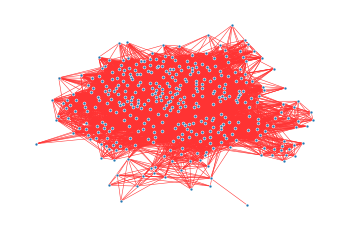

In [18]:
sd.plot.network(network_observations, layout='kk', edge_color='#f33')[3]

In [23]:
# elements in collection 'stad_murih' look like this:
#   {
#     "_key": "IAM01_1_IAM01_2",
#     "_id": "stad_murih/IAM01_1_IAM01_2",
#     "_from": "murih_samples/IAM01_1",
#     "_to": "murih_samples/IAM01_2",
#     "_rev": "_d0RrFnm---",
#     "weight": 0.16877969889980557
#   }

edgesCollection = db["stad_murih"]
edgesCollection.truncate()
docs = []
for i in range(len(np.nonzero(adjacency_matrix)[0])):
    x = np.nonzero(adjacency_matrix)[0][i]
    y = np.nonzero(adjacency_matrix)[1][i]
    x_key = data.iloc[x]["_key"]
    y_key = data.iloc[y]["_key"]

    doc = edgesCollection.createDocument()
    doc['_key'] = x_key + '_' + y_key
    doc['_from'] = "murih_samples/" + x_key
    doc['_to'] = "murih_samples/" + y_key
    doc["weight"] = adjacency_matrix[x][y]
    docs.append(doc)
edgesCollection.bulkSave(docs)

14649